In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

# remove warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\CDUNGCA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
np.random.seed(500)

In [3]:
# Load the data
Corpus = pd.read_csv('data/data.csv')

In [4]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  194 non-null    object
 1   fulltext  189 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [5]:
Corpus.head()

,category,fulltext
0,accountability,United Nations A/60/846/Add.6 Gener...
1,accountability,United Nations A/71/729 General Asse...
2,accountability,United Nations A/72/492 General Asse...
3,accountability,United Nations A/72/492/Add.2 Genera...
4,accountability,United Nations A/73/688 General Asse...


In [6]:
Corpus["category"].value_counts()

category
travel                  75
human resources         66
accountability          42
health and wellbeing    11
Name: count, dtype: int64

In [7]:
Corpus.isnull().sum()

category    0
fulltext    5
dtype: int64

In [8]:
# category distribution before data cleaning
#Corpus['category'].value_counts().plot(kind='bar')
#plt.xlabel('Category')
#plt.ylabel('Count')
#plt.rc('font', size=14)
#plt.title('Category Distribution Before Data Cleaning')
#plt.show()

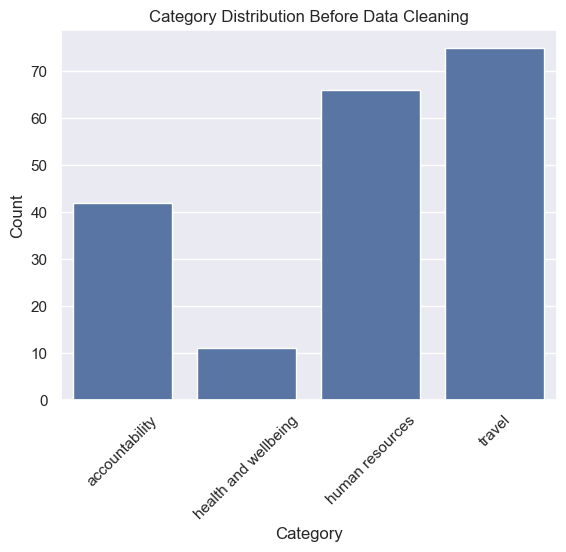

In [9]:
# create catgory distribution using seaborn
sns.set(style="darkgrid")
sns.countplot(x='category', data=Corpus)
plt.xlabel('Category')
# rotate the xlabel
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Category Distribution Before Data Cleaning')
plt.show()

### Data Pre-processing

1. Remove rows with blank values
2. Change all to lower case
3. Tokenization
4. Remove stop words
5. Remove non-alpha text
6. Word Lemmatization


In [10]:
Corpus.isnull().sum()

category    0
fulltext    5
dtype: int64

In [11]:
# Step 0: We only have 10 records with category health and wellbeing. We will remove these records since they are not enough to train the model.
Corpus = Corpus[Corpus['category'] != 'health and wellbeing']
# Step 1: Remove missing values
Corpus['fulltext'].dropna(inplace=True)
# Step 2: Change all the text to lower case
Corpus['fulltext'] = [entry.lower() if isinstance(entry, str) else '' for entry in Corpus['fulltext']]
# Step 3: Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['fulltext'] = [word_tokenize(entry) for entry in Corpus['fulltext']]
# Step 4: Remove stop words, non-alphabet and perfom word lemmatization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['fulltext']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = " ".join(Final_words)
    
Corpus.head()

,category,fulltext,text_final
0,accountability,"[united, nations, a/60/846/add.6, general, ass...",united nation general assembly distr general j...
1,accountability,"[united, nations, a/71/729, general, assembly,...",united nation general assembly distr general d...
2,accountability,"[united, nations, a/72/492, general, assembly,...",united nation general assembly distr general s...
3,accountability,"[united, nations, a/72/492/add.2, general, ass...",united nation general assembly distr general m...
4,accountability,"[united, nations, a/73/688, general, assembly,...",united nation general assembly distr general d...


In [12]:
# Check number of rows for missing values
Corpus.isnull().sum()

category      11
fulltext      11
text_final    11
dtype: int64

In [13]:
# Remove rows with empty fields
Corpus = Corpus.dropna()

In [14]:
# Re-check number of rows for missing values
Corpus.isnull().sum()

category      0
fulltext      0
text_final    0
dtype: int64

In [15]:
Corpus["category"].value_counts()

category
human resources    66
travel             64
accountability     42
Name: count, dtype: int64

In [16]:
# category distribution after data cleaning
#Corpus['category'].value_counts().plot(kind='bar')
#plt.xlabel('Category')
#plt.ylabel('Count')
#plt.rc('font', size=14)
#plt.title('Category Distribution After Data Cleaning')
#plt.show()

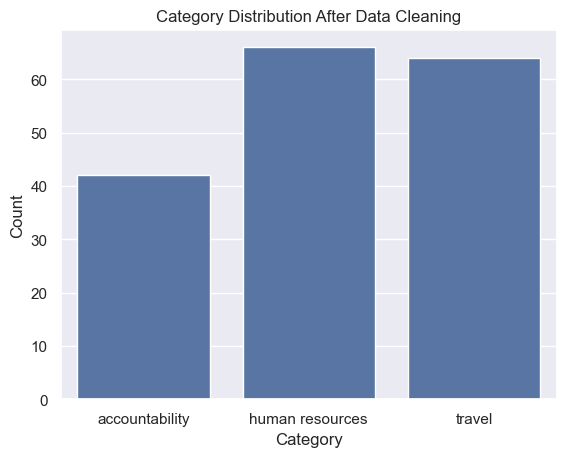

In [17]:
# create catgory distribution using seaborn
sns.set(style="darkgrid")
sns.countplot(x='category', data=Corpus)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Distribution After Data Cleaning')
plt.show()


### Prepare Train and Test Data

In [18]:
# Prepare test data
X_train, X_test, y_train, y_test = train_test_split(Corpus['text_final'], Corpus['category'], test_size=0.3)

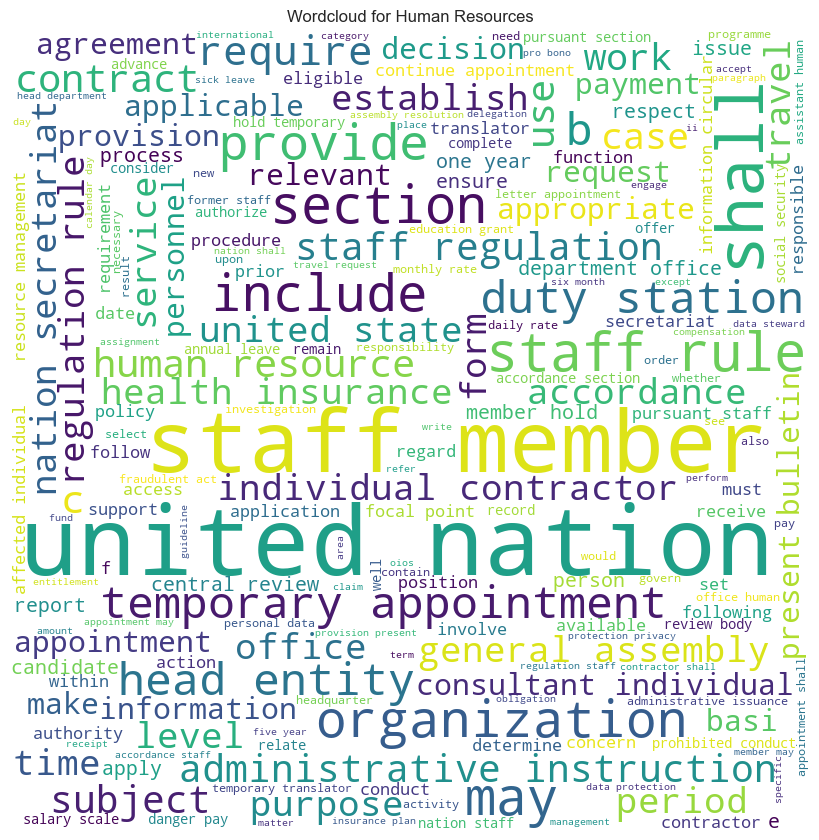

In [19]:
# use wordcloud to visualize the words in the text_final where category is 'human resources'
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(' '.join(Corpus[Corpus['category'] == 'human resources']['text_final']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.rc('font', size=24)
plt.title('Wordcloud for Human Resources')
plt.show()

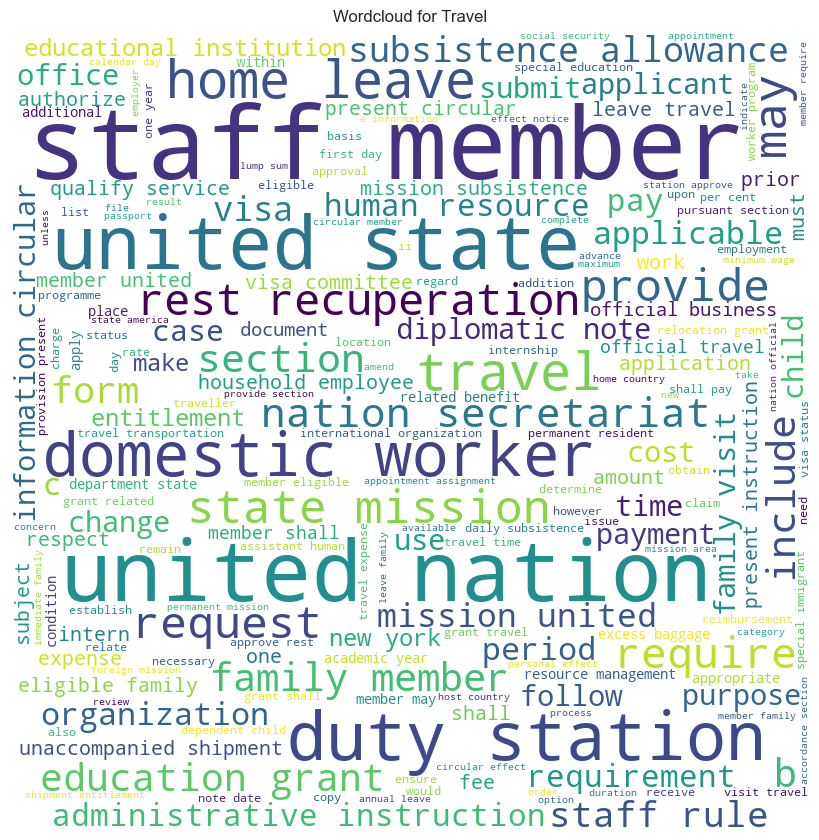

In [20]:
# use wordcloud to visualize the words in the text_final where category is 'travel'
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(' '.join(Corpus[Corpus['category'] == 'travel']['text_final']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.rc('font', size=24)
plt.title('Wordcloud for Travel')
plt.show()

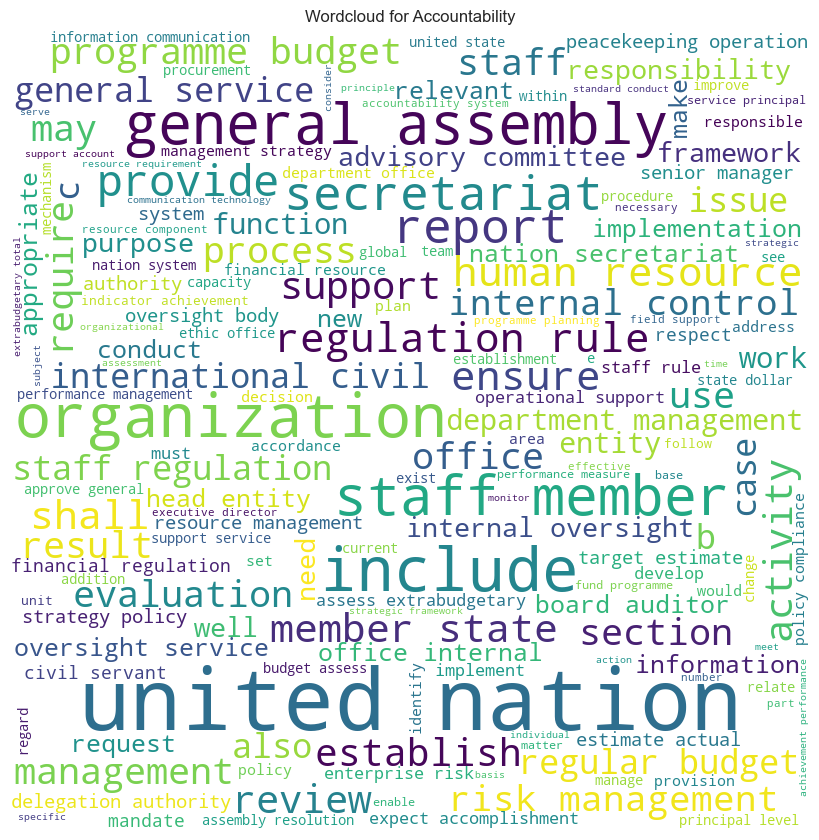

In [21]:
# use wordcloud to visualize the words in the text_final where category is 'accountability'
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords.words('english'),
                min_font_size = 10).generate(' '.join(Corpus[Corpus['category'] == 'accountability']['text_final']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.rc('font', size=24)
plt.title('Wordcloud for Accountability')
plt.show()

### Encode category

In [22]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [23]:
# Define labels and target names
labels = [0, 1, 2]
target_names = ['accountability', 'human resources', 'travel']

### Using DummyClassifier - Baseline Model

In [24]:
# Use CountVectorizer - DummyClassifier - Baseline
cvect_base_pipe = ''
cvect_base_acc = ''
   
cvect_base_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('dclass', DummyClassifier(strategy='most_frequent'))])
cvect_base_pipe.fit(X_train, y_train)

print(cvect_base_pipe.named_steps)

cvect_base_acc = round((cvect_base_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Baseline Model - Accuracy: {cvect_base_acc}')

print(classification_report(y_test, cvect_base_pipe.predict(X_test), labels=labels, target_names=target_names))

{'cvect': CountVectorizer(), 'dclass': DummyClassifier(strategy='most_frequent')}
CountVectorizer - Baseline Model - Accuracy: 38.46
                 precision    recall  f1-score   support

 accountability       0.00      0.00      0.00        12
human resources       0.38      1.00      0.56        20
         travel       0.00      0.00      0.00        20

       accuracy                           0.38        52
      macro avg       0.13      0.33      0.19        52
   weighted avg       0.15      0.38      0.21        52



### Using CountVectorizer: default and using best parameter

In [25]:
# Use CountVectorizer - Logistic Regression - Default
cvect_lgr_pipe = ''
cvect_lgr_default_acc = ''
   
cvect_lgr_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('lgr', LogisticRegression(max_iter=10000))])
cvect_lgr_pipe.fit(X_train, y_train)

print(cvect_lgr_pipe.named_steps)

cvect_lgr_default_acc = round((cvect_lgr_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Default - Accuracy: {cvect_lgr_default_acc}')

print(classification_report(y_test, cvect_lgr_pipe.predict(X_test), labels=labels, target_names=target_names))

{'cvect': CountVectorizer(), 'lgr': LogisticRegression(max_iter=10000)}
CountVectorizer - Logistic Regression - Default - Accuracy: 55.77
                 precision    recall  f1-score   support

 accountability       0.44      0.58      0.50        12
human resources       0.52      0.55      0.54        20
         travel       0.73      0.55      0.63        20

       accuracy                           0.56        52
      macro avg       0.56      0.56      0.56        52
   weighted avg       0.58      0.56      0.56        52



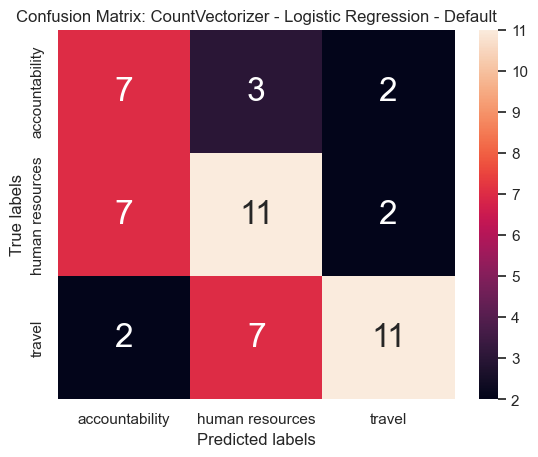

In [26]:
# Confusion Matrix - CountVectorizer - Logistic Regression - Default
preds = cvect_lgr_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
# show xlabels
#plt.xlabel('Predicted Label')
# show ylabels
#plt.ylabel('True Label')
#plt.title('CountVectorizer - Logistic Regression - Default')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Logistic Regression - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [27]:
# Use CountVectorizer - Logistic Regression - Grid Search
lgr_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'lgr__C': [0.1, 1, 10, 100]}
cvect_lgr_grid = ''
cvect_lgr_best_acc = ''

cvect_lgr_grid = GridSearchCV(cvect_lgr_pipe, param_grid=lgr_params)
cvect_lgr_grid.fit(X_train, y_train)

print(cvect_lgr_grid.best_params_)

cvect_lgr_lgrbest_acc = round((cvect_lgr_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Grid Search - Accuracy: {cvect_lgr_lgrbest_acc}')

print(classification_report(y_test, cvect_lgr_grid.predict(X_test), labels=labels, target_names=target_names))

{'cvect__max_features': 1000, 'lgr__C': 0.1}
CountVectorizer - Logistic Regression - Grid Search - Accuracy: 59.62
                 precision    recall  f1-score   support

 accountability       0.50      0.67      0.57        12
human resources       0.55      0.60      0.57        20
         travel       0.79      0.55      0.65        20

       accuracy                           0.60        52
      macro avg       0.61      0.61      0.60        52
   weighted avg       0.63      0.60      0.60        52



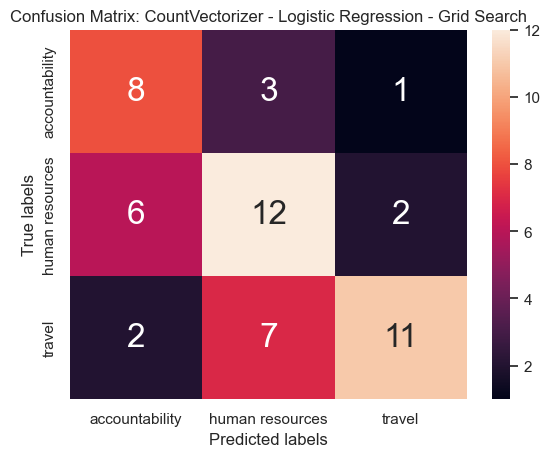

In [28]:
# Confusion Matrix - CountVectorizer - Logistic Regression - Grid Search
preds = cvect_lgr_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('CountVectorizer - Logistic Regression - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Logistic Regression - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [29]:
# Use CountVectorizer - Naive Bayes - Default
cvect_nb_pipe = ''
cvect_nb_default_acc = ''
   
cvect_nb_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('bayes', MultinomialNB())])
cvect_nb_pipe.fit(X_train, y_train)

print(cvect_nb_pipe.named_steps)

cvect_nb_default_acc = round((cvect_nb_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Naive Bayes - Default - Accuracy: {cvect_nb_default_acc}')

print(classification_report(y_test, cvect_nb_pipe.predict(X_test), labels=labels, target_names=target_names))


{'cvect': CountVectorizer(), 'bayes': MultinomialNB()}
CountVectorizer - Naive Bayes - Default - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.67      0.83      0.74        12
human resources       0.75      0.60      0.67        20
         travel       0.86      0.90      0.88        20

       accuracy                           0.77        52
      macro avg       0.76      0.78      0.76        52
   weighted avg       0.77      0.77      0.77        52



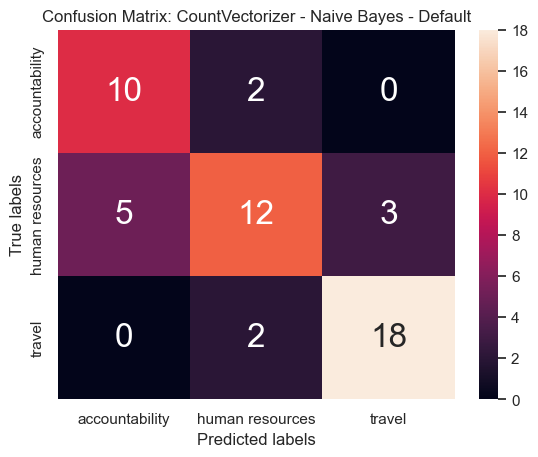

In [30]:
# Confusion Matrix - CountVectorizer - Naive Bayes - Default
preds = cvect_nb_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('CountVectorizer - Naive Bayes - Default')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Naive Bayes - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [31]:
# Use CountVectorizer - Naive Bayes - Grid Search
nb_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'bayes__alpha': [0.1, 1, 10, 100]}

cvect_nb_grid = ''
cvect_nb_best_acc = ''

cvect_nb_grid = GridSearchCV(cvect_nb_pipe, param_grid=nb_params)
cvect_nb_grid.fit(X_train, y_train)

print(cvect_nb_grid.best_params_)

cvect_nb_best_acc = round((cvect_nb_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Naive Bayes - Grid Search - Accuracy: {cvect_nb_best_acc}')

print(classification_report(y_test, cvect_nb_grid.predict(X_test), labels=labels, target_names=target_names))

{'bayes__alpha': 0.1, 'cvect__max_features': 2000}
CountVectorizer - Naive Bayes - Grid Search - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.67      0.83      0.74        12
human resources       0.75      0.60      0.67        20
         travel       0.86      0.90      0.88        20

       accuracy                           0.77        52
      macro avg       0.76      0.78      0.76        52
   weighted avg       0.77      0.77      0.77        52



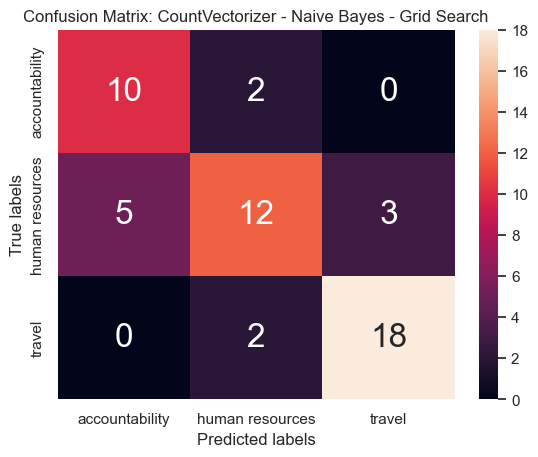

In [32]:
# Confusion Matrix - CountVectorizer - Naive Bayes - Grid Search
preds = cvect_nb_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('CountVectorizer - Naive Bayes - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Naive Bayes - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [33]:
# Use CountVectorizer - Support Vector Machine - Default
cvect_svm_pipe = ''
cvect_svm_default_acc = ''
   
cvect_svm_pipe = Pipeline([('cvect', CountVectorizer()),
                       ('svc', SVC(probability=True))])
cvect_svm_pipe.fit(X_train, y_train)

print(cvect_svm_pipe.named_steps)

cvect_svm_default_acc = round((cvect_svm_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Support Vector Machine - Default - Accuracy: {cvect_svm_default_acc}')

print(classification_report(y_test, cvect_svm_pipe.predict(X_test), labels=labels, target_names=target_names))


{'cvect': CountVectorizer(), 'svc': SVC(probability=True)}
CountVectorizer - Support Vector Machine - Default - Accuracy: 50.0
                 precision    recall  f1-score   support

 accountability       0.71      0.42      0.53        12
human resources       0.43      0.90      0.58        20
         travel       1.00      0.15      0.26        20

       accuracy                           0.50        52
      macro avg       0.71      0.49      0.46        52
   weighted avg       0.71      0.50      0.45        52



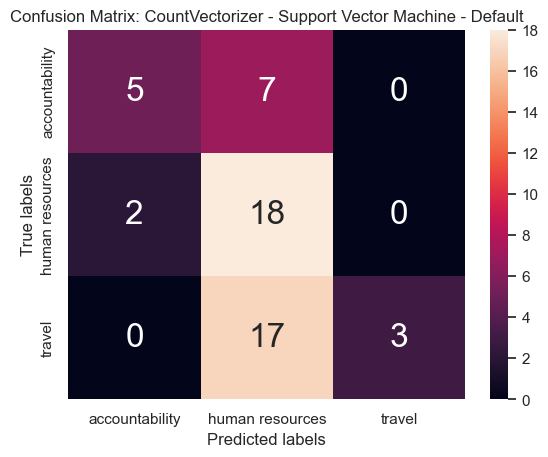

In [34]:
# Confusion Matrix - CountVectorizer - Support Vector Machive - Default
preds = cvect_svm_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('CountVectorizer - Support Vector Machine - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Support Vector Machine - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [35]:
# Use CountVectorizer - Support Vector Machine - Grid Search
svm_params = {'cvect__max_features': [100, 500, 1000, 2000],
         'svc__C': [0.1, 1, 10, 100]}

cvect_svm_grid = ''
cvect_svm_best_acc = ''

cvect_svm_grid = GridSearchCV(cvect_svm_pipe, param_grid=svm_params)
cvect_svm_grid.fit(X_train, y_train)

print(cvect_svm_grid.best_params_)

cvect_svm_best_acc = round((cvect_svm_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Support Vector Machine - Grid Search - Accuracy: {cvect_svm_best_acc}')

print(classification_report(y_test, cvect_svm_grid.predict(X_test), labels=labels, target_names=target_names))

{'cvect__max_features': 2000, 'svc__C': 100}
CountVectorizer - Support Vector Machine - Grid Search - Accuracy: 69.23
                 precision    recall  f1-score   support

 accountability       0.67      0.67      0.67        12
human resources       0.57      0.80      0.67        20
         travel       1.00      0.60      0.75        20

       accuracy                           0.69        52
      macro avg       0.75      0.69      0.69        52
   weighted avg       0.76      0.69      0.70        52



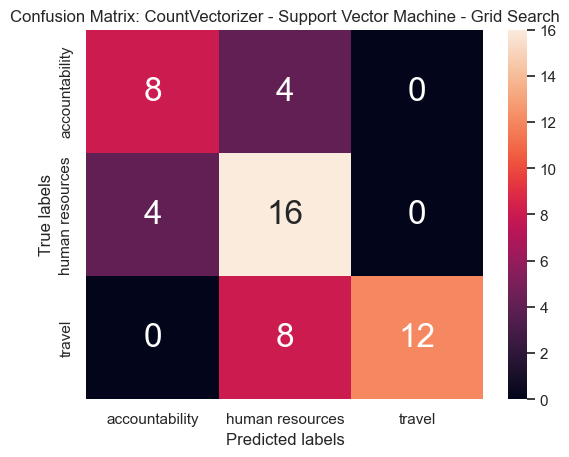

In [36]:
# Confusion Matrix - CountVectorizer - Support Vector Machine - Grid Search
preds = cvect_svm_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('CountVectorizer - Support Vector Machine - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Support Vector Machine - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

### Using TfidfVectorizer

In [37]:
# Use TfidVectorizer - Logistic Regression - Default
tvect_lgr_pipe = ''
tvect_lgr_default_acc = ''
   
tvect_lgr_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('lgr', LogisticRegression(max_iter=10000))])
tvect_lgr_pipe.fit(X_train, y_train)

tvect_lgr_pipe.named_steps

tvect_lgr_default_acc = round((tvect_lgr_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Logistic Regression - Default - Accuracy: {tvect_lgr_default_acc}')

print(classification_report(y_test, tvect_lgr_pipe.predict(X_test), labels=labels, target_names=target_names))


TfidVectorizer - Logistic Regression - Default - Accuracy: 75.0
                 precision    recall  f1-score   support

 accountability       0.73      0.92      0.81        12
human resources       0.68      0.65      0.67        20
         travel       0.83      0.75      0.79        20

       accuracy                           0.75        52
      macro avg       0.75      0.77      0.76        52
   weighted avg       0.75      0.75      0.75        52



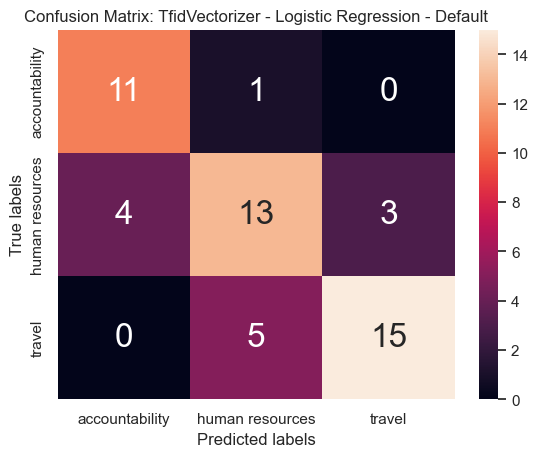

In [38]:
# Confusion Matrix - TfidVectorizer - Logistic Regression - Default
preds = tvect_lgr_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Logistic Regression - Default')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: TfidVectorizer - Logistic Regression - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [39]:
# Use TfidVectorizer - Logistic Regression - Grid Search
lgr_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'lgr__C': [0.1, 1, 10, 100]}
tvect_lgr_grid = ''
tvect_lgr_best_acc = ''

tvect_lgr_grid = GridSearchCV(tvect_lgr_pipe, param_grid=lgr_params)
tvect_lgr_grid.fit(X_train, y_train)

print(tvect_lgr_grid.best_params_)

tvect_lgr_lgrbest_acc = round((tvect_lgr_grid.score(X_test, y_test)*100), ndigits=2)
print(f'CountVectorizer - Logistic Regression - Grid Search - Accuracy: {tvect_lgr_lgrbest_acc}')

print(classification_report(y_test, tvect_lgr_grid.predict(X_test), labels=labels, target_names=target_names))

{'lgr__C': 100, 'tvect__max_features': 1000}
CountVectorizer - Logistic Regression - Grid Search - Accuracy: 71.15
                 precision    recall  f1-score   support

 accountability       0.59      0.83      0.69        12
human resources       0.65      0.65      0.65        20
         travel       0.93      0.70      0.80        20

       accuracy                           0.71        52
      macro avg       0.72      0.73      0.71        52
   weighted avg       0.74      0.71      0.72        52



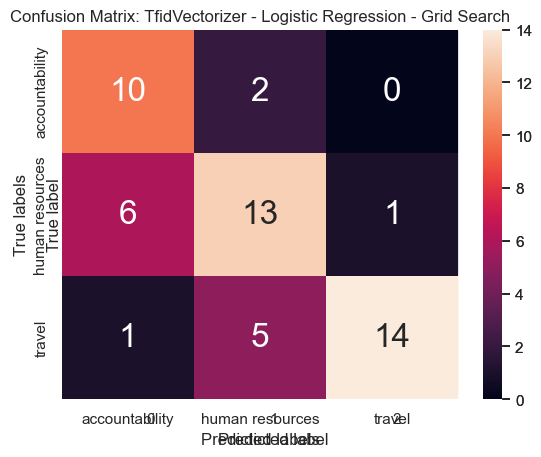

In [40]:
# Confusion Matrix - TfidVectorizer - Logistic Regression - Grid Search
preds = tvect_lgr_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Logistic Regression - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: TfidVectorizer - Logistic Regression - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

#### Naive Bayes

In [41]:
# Use TfidVectorizer - Naive Bayes - Default
tvect_nb_pipe = ''
tvect_nb_default_acc = ''
   
tvect_nb_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('bayes', MultinomialNB())])
tvect_nb_pipe.fit(X_train, y_train)

print(tvect_nb_pipe.named_steps)

tvect_nb_default_acc = round((tvect_nb_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Naive Bayes - Default - Accuracy: {tvect_nb_default_acc}')

print(classification_report(y_test, tvect_nb_pipe.predict(X_test), labels=labels, target_names=target_names))

{'tvect': TfidfVectorizer(), 'bayes': MultinomialNB()}
TfidVectorizer - Naive Bayes - Default - Accuracy: 80.77
                 precision    recall  f1-score   support

 accountability       0.77      0.83      0.80        12
human resources       0.75      0.75      0.75        20
         travel       0.89      0.85      0.87        20

       accuracy                           0.81        52
      macro avg       0.80      0.81      0.81        52
   weighted avg       0.81      0.81      0.81        52



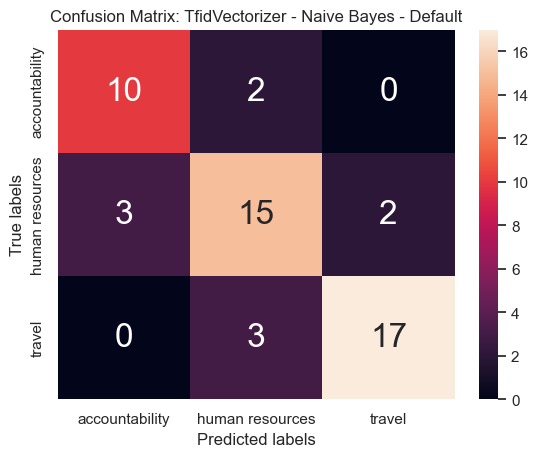

In [42]:
# Confusion Matrix - TfidVectorizer - Naive Bayes - Default
preds = tvect_nb_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Naive Bayes - Default')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: TfidVectorizer - Naive Bayes - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [43]:
# Use TfidVectorizer - Naive Bayes - Grid Search
nb_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'bayes__alpha': [0.1, 1, 10, 100]}

tvect_nb_grid = ''
tvect_nb_best_acc = ''

tvect_nb_grid = GridSearchCV(tvect_nb_pipe, param_grid=nb_params)
tvect_nb_grid.fit(X_train, y_train)

print(tvect_nb_grid.best_params_)

tvect_nb_best_acc = round((tvect_nb_grid.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Naive Bayes - Best - Accuracy: {tvect_nb_best_acc}')

print(classification_report(y_test, tvect_nb_grid.predict(X_test), labels=labels, target_names=target_names))


{'bayes__alpha': 0.1, 'tvect__max_features': 2000}
TfidVectorizer - Naive Bayes - Best - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.71      1.00      0.83        12
human resources       0.75      0.60      0.67        20
         travel       0.84      0.80      0.82        20

       accuracy                           0.77        52
      macro avg       0.77      0.80      0.77        52
   weighted avg       0.78      0.77      0.76        52



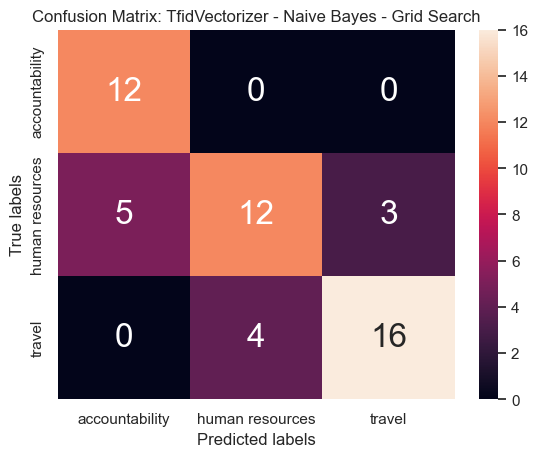

In [44]:
# Confusion Matrix - TfidVectorizer - Naive Bayes - Grid Search
preds = tvect_nb_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Naive Bayes - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: TfidVectorizer - Naive Bayes - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [45]:
# Use TfidVectorizer - Support Vector Machine - Default
tvect_svm_pipe = ''
tvect_svm_default_acc = ''
   
tvect_svm_pipe = Pipeline([('tvect', TfidfVectorizer()),
                       ('svc', SVC(probability=True))])
tvect_svm_pipe.fit(X_train, y_train)

print(tvect_svm_pipe.named_steps)

tvect_svm_default_acc = round((tvect_svm_pipe.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - SVM - Default Accuracy: {cvect_svm_default_acc}')

print(classification_report(y_test, tvect_svm_pipe.predict(X_test), labels=labels, target_names=target_names))


{'tvect': TfidfVectorizer(), 'svc': SVC(probability=True)}
TfidVectorizer - SVM - Default Accuracy: 50.0
                 precision    recall  f1-score   support

 accountability       0.62      0.83      0.71        12
human resources       0.68      0.65      0.67        20
         travel       0.88      0.75      0.81        20

       accuracy                           0.73        52
      macro avg       0.73      0.74      0.73        52
   weighted avg       0.75      0.73      0.73        52



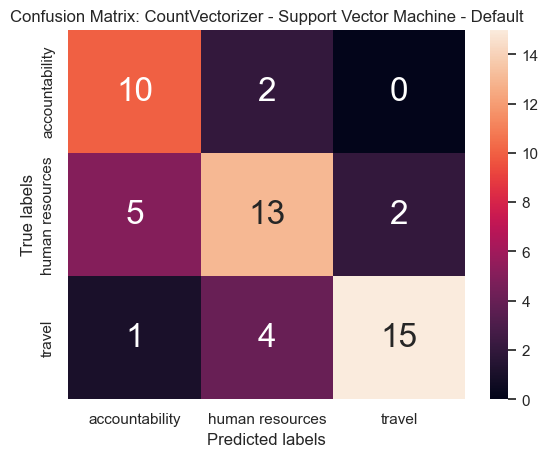

In [46]:
# Confusion Matrix - TfidVectorizer - Support Vector Machine - Default
preds = tvect_svm_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Support Vector Machine - Default')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: CountVectorizer - Support Vector Machine - Default'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);

In [47]:
# Use TfidVectorizer - Support Vector Machine - Grid Search
svm_params = {'tvect__max_features': [100, 500, 1000, 2000],
         'svc__C': [0.1, 1, 10, 100]}

tvect_svm_grid = ''
tvect_svm_best_acc = ''

tvect_svm_grid = GridSearchCV(tvect_svm_pipe, param_grid=svm_params)
tvect_svm_grid.fit(X_train, y_train)

print(tvect_svm_grid.best_params_)

tvect_svm_best_acc = round((tvect_svm_grid.score(X_test, y_test)*100), ndigits=2)
print(f'TfidVectorizer - Support Vector Machine - Grid Search - Accuracy: {tvect_svm_best_acc}')

print(classification_report(y_test, tvect_svm_grid.predict(X_test), labels=labels, target_names=target_names))

{'svc__C': 10, 'tvect__max_features': 2000}
TfidVectorizer - Support Vector Machine - Grid Search - Accuracy: 76.92
                 precision    recall  f1-score   support

 accountability       0.63      1.00      0.77        12
human resources       0.76      0.65      0.70        20
         travel       0.94      0.75      0.83        20

       accuracy                           0.77        52
      macro avg       0.78      0.80      0.77        52
   weighted avg       0.80      0.77      0.77        52



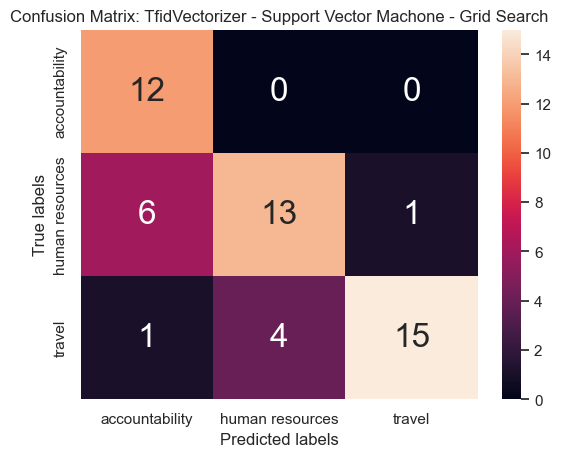

In [48]:
# Confusion Matrix - TfidVectorizer - Support Vector Machine - Grid Search
preds = tvect_svm_grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, preds)
#disp = ConfusionMatrixDisplay(conf_matrix)
#disp.plot()
# add title
#plt.rc('font', size=12)
#plt.axis("off")
#plt.title('TfidVectorizer - Support Vector Machine - Grid Search')
#plt.show()
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix: TfidVectorizer - Support Vector Machone - Grid Search'); 
ax.xaxis.set_ticklabels(['accountability', 'human resources', 'travel']); ax.yaxis.set_ticklabels(['accountability', 'human resources', 'travel']);